All of the necessary imports

In [25]:
import numpy as np #basic python library
import matplotlib.pyplot as plt #For plotting results

## Import Landlab components
from landlab.components import DepressionFinderAndRouter #Pit filling
from landlab.components import PriorityFloodFlowRouter #Flow routing

#SPACE model
from landlab.components import Space #SPACE model
from landlab.components import FastscapeEroder #calculates the amount of erosion at each node
from landlab.components import SinkFillerBarnes #replaces pits with shallow gradients for draining

## Import Landlab utilities
from landlab import RasterModelGrid #Grid utility
from landlab import imshow_grid #For plotting results
from landlab.io import read_esri_ascii #to read in an ascii file
from landlab.io import read_asc_header #to read in the header of the ascii file
%matplotlib inline

Retrieving the DEM files and importing into progam as a rasterModelGrid

[403157]


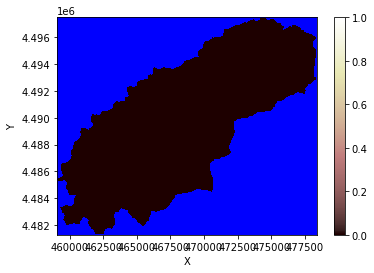

In [26]:
#Set directory paths to retrieve the asc file
path_project = r"C:/Users/gsbir/Documents/EES_393/" # add the path to the asc file    #this should access my H drive
filename_dem = "saucon_txt.txt" #the name of the asc file
path_dem = path_project + filename_dem

#now read the header of the asc file (where there is ncols nrows cell size and nodata value) into the string variable dem_header
dem_header = read_asc_header(open(path_dem, 'r'))
#use the above to see your grid dimensions, what the no data value is etc...

#generate new grid and add DEM values into 'topographic__elevation'
(mg, z) = read_esri_ascii(path_dem, name= 'topographic__elevation', halo = 1)


#set the watershed boundary condition and the function returns a integer which is the outlet_id so this is set equal to a variable so we can view this
outlet_id = mg.set_watershed_boundary_condition(z, nodata_value = -9999, return_outlet_id=True)
#This should find your outlet node automatically and outlet_id will be empty if a single outlet was not found

print(outlet_id) #prints out the outlet_id

#print(mg.number_of_nodes) 

#print(mg.at_node.keys()) #Shows the node attributes
#print(mg.corners_at_left_edge)

#this line can look at the boundary status of the nodes to see where the outlet is
#imshow_grid(mg, mg.status_at_node, color_for_closed = 'purple')

# %% Hydrologically condition DEM (fill sinks)
sfb = SinkFillerBarnes(mg, surface=z, method='D8', fill_flat=False) #creating an instance of sinkfillerbarnes 
sfb.run_one_step() #This is important to ensure that your future flow routing will work properly. - run the sinkfiller barnes once

imshow_grid(mg, mg.status_at_node, color_for_closed = 'blue') #creates a graph showing the red and the closed boundaries are set to blue, black is the landscape and white is the outlet ID (cannot see it at this level)

Adding new nodes to the rasterModelGrid: soil__depth, bedrock__elevation 

In [27]:
#Set grid parameters 
#these numbers are taken from the ascii header file
num_rows = 712
num_columns = 595
node_next_to_outlet = num_columns + 1
node_spacing = 27.097698258644

#Set model timestep
timestep = 1 #years

#Set model run time
run_time = 2 #years
uplift_rate = .001 # m/year
uplift_per_timestep = uplift_rate * timestep


#Add field 'soil__depth' to the grid with 0s for now
mg.add_zeros('node', 'soil__depth')

#Set 2 m of initial soil depth at core nodes
mg.at_node['soil__depth'][mg.core_nodes] = 2.0 #meters 

#Add field 'bedrock__elevation' to the grid with 0s for now
mg.add_zeros('bedrock__elevation', at='node')

#Subtract 'soil__depth' and 'bedrock__elevation' to yield 'topographic elevation'
mg.at_node['bedrock__elevation'][:] = mg.at_node['topographic__elevation'] - mg.at_node['soil__depth']



Setting Boundary Conditions of the Grid

In [28]:
#Close all model boundary edges
mg.set_closed_boundaries_at_grid_edges(bottom_is_closed=True,
                                       left_is_closed=True,
                                       right_is_closed=True,
                                       top_is_closed=True)


Instantiating the FlowRouter and the DepressionFinder and Router and Space model

In [29]:
#Instantiate flow Router as fr
fr = PriorityFloodFlowRouter(mg,surface='topographic__elevation', flow_metric='D8', runoff_rate=None, update_flow_depressions=True, depression_handler='fill', exponent=1, epsilon=False, accumulate_flow=True, accumulate_flow_hill=False, separate_hill_flow=False, update_hill_depressions=False, update_hill_flow_instantaneous=False, hill_flow_metric='D8', hill_exponent=1, suppress_out=False)
fr.run_one_step() #run the flow router once 

#Instantiate the depressionfinder and router as df
df = DepressionFinderAndRouter(mg, 'D8', True) 

#instantiate the fascape eroder as fsc 
fsc = FastscapeEroder(mg, K_sp=.001,m_sp=.5, n_sp=1)  #-- currently not being used

#Instantiate SPACE model with chosen parameters as sp
sp = Space(mg, K_sed=0.01, K_br=0.001, F_f=0., phi=0., H_star=1., v_s=5.0, m_sp=0.5, n_sp=1.0, sp_crit_sed=0, sp_crit_br=0)

['topographic__elevation', 'sediment_fill__depth', 'soil__depth', 'bedrock__elevation', 'water__unit_flux_in', 'flow__link_to_receiver_node', 'drainage_area', 'flow__upstream_node_order', 'flow__receiver_node', 'surface_water__discharge', 'topographic__steepest_slope', 'flow__receiver_proportions', 'squared_length_adjacent', 'depression_free_elevation', 'depression__depth', 'depression__outlet_node', 'is_pit', 'flood_status_code', 'sediment__flux']


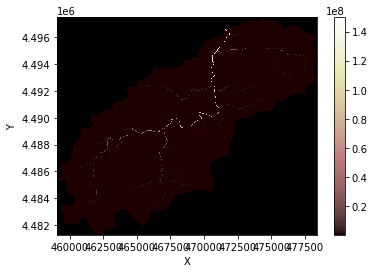

In [30]:
print(mg.at_node.keys()) #prints out all of the information that the nodes contain
imshow_grid(mg, 'drainage_area') #makes a graph of the node information 'drainage_area

Run the Model 

In [31]:

#Set elapsed time to zero
elapsed_time = 0 #years

#Set timestep count to zero
count = 0

#Array to save sediment flux values
#sed_flux = np.zeros(int(run_time // timestep))
sed_flux = [0] * (run_time)                                

#This will iterate through all of the years needed and will essentially run the model
while elapsed_time < run_time: #time units of years
    mg.at_node['bedrock__elevation'] += uplift_per_timestep  #adding uplift to the bedrock
    mg.at_node['topographic__elevation'] = mg.at_node['bedrock__elevation'] + mg.at_node['soil__depth'] #changing the elevation to account for the uplift
    
    #fsc.run_one_step(dt=timestep) #not needed currently 
    #df.map_depressions() #not needed currently 

    #Run the flow router for one step (one step for each year)
    fr.run_one_step()
    
    
    #Get list of nodes in depressions; only
    #used if using DepressionFinderAndRouter
    flooded = np.where(df.flood_status==3)[0] #flooded is a list of nodes of the depressions in the landscape
    sp.run_one_step(dt = timestep) #runs the space model (sp) for one timestep

    #Save sediment flux value to array
    sed_flux[count] = mg.at_node['sediment__flux'][node_next_to_outlet] ##creates the array sed_flux  and adds the sediment_flux value from the node into it
    
    elapsed_time += timestep #Add timestep value to elapsed time
    
    print(count) #prints out a number that is increaseing for each year - this is to keep track of the model as it is running for a large amount of time
    count += 1 #Increase timestep count

0
1


Create the Sediment Flux Figure

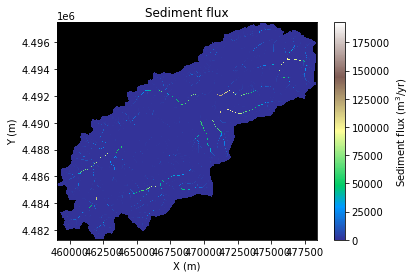

In [32]:
#Instantiate an empty plot
figsed = plt.figure()

#Instantiate subplot empty
plot = plt.subplot()

#Create sed_flux graph that shows the landscape with the nodes where ther is sediment flux in different colors- using landlab utility imshow_grid
imshow_grid(mg, 'sediment__flux', plot_name='Sediment flux', var_name = 'Sediment flux', var_units=r'm$^3$/yr', grid_units=('m', 'm'), cmap='terrain')

Create the Topographic Elevation Figure

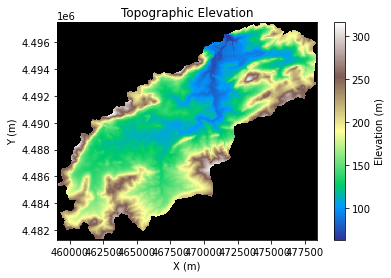

In [33]:
#Instantiate figure as empty plot
figelev = plt.figure()

#Instantiate subplot as empty plot
plot = plt.subplot()

#Create a topographic elevation plot that shows the elevation of the landscape in diff colors - using landlab utility imshow_grid
imshow_grid(mg, 'topographic__elevation', plot_name='Topographic Elevation', var_name = 'Elevation', var_units=r'm', grid_units=('m', 'm'), cmap='terrain',color_for_background=None)

Create the Soil Depth Figure

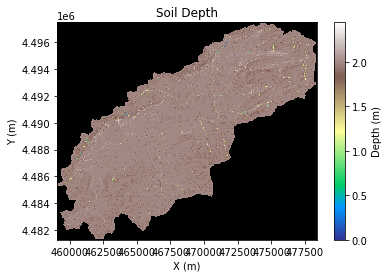

In [34]:
#Instantiate figure as empty plot
fig = plt.figure()

#Instantiate subplot as empty plot
plot = plt.subplot()

#Create a graph showing the soil depth at each node in the landscape - using landlab utility imshow_grid
imshow_grid(mg, 'soil__depth', plot_name='Soil Depth', var_name = 'Depth', var_units=r'm', grid_units=('m', 'm'), cmap='terrain')

Create the Bedrock Elevation Figure

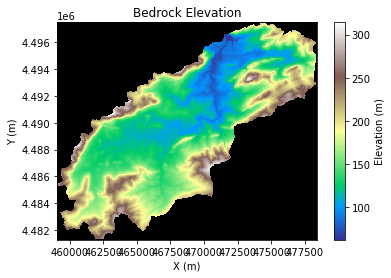

In [35]:
#Instantiate figure as empty plot
fig = plt.figure()

#Instantiate subplot as empty plot
plot = plt.subplot()

#Create a graph showing the bedrock elevation of the landscape - using landlab utility imshow_grid
imshow_grid(mg, 'bedrock__elevation', plot_name='Bedrock Elevation', var_name = 'Elevation', var_units=r'm', grid_units=('m', 'm'), cmap='terrain')

Create the Sedimentograph

Text(0, 0.5, 'Sediment flux [m$^3$/yr]')

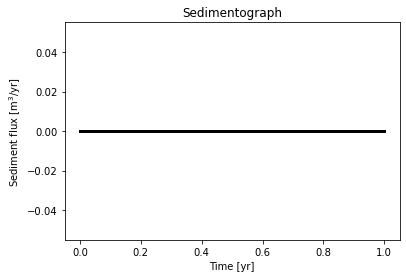

In [36]:
#Instantiate figure as an empty plot
fig = plt.figure()

#Instantiate subplot as an empty plot
sedfluxplot = plt.subplot()

#Creates the information in the graph with the runtim values from 0 to the end of the run_time , and the sed_flux array creates while the model was running
sedfluxplot.plot(np.arange(run_time),sed_flux, color = 'k', linewidth = 3)

#Add axis labels to the plot 
sedfluxplot.set_title('Sedimentograph') #title
sedfluxplot.set_xlabel('Time [yr]') #x axis label
sedfluxplot.set_ylabel(r'Sediment flux [m$^3$/yr]') #y axis label